In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
from scipy.spatial import KDTree
from shapely.geometry import LineString
import numpy.linalg as LA
import copy
import time
import math
import json

In [11]:
class CollisionChecker():
    def __init__(self,obstacles):
        self.obstacles = obstacles
    
    def lineLineIntersection(self,line1,line2):
        # each line is a tuple of end points ((x1,y1),(x2,y2))
        # returns true if line1 and line2 intersect
        (x1,y1),(x2,y2) = line1
        (x3,y3),(x4,y4) = line2
        line1String = LineString([line1[0], line1[1]])
        line2String = LineString([line2[0], line2[1]])
        return line1String.intersects(line2String)
        
    
    def getObstacleLines(self,obstacle):
        # obstacle is list of points for the obstacle
        # returns a list of lines given by pairs of points for all points on a given obstacle
        obstacleLines = [(obstacle[-1],obstacle[0])]
        for i in range(0,len(obstacle)-1):
            obstacleLines.append((obstacle[i],obstacle[i+1]))
        return obstacleLines

    def lineIntersectsObstacles(self,line):
        # returns true if a line between the points intersects any obstacles
        for obstacle in self.obstacles:
            obstacleLines = self.getObstacleLines(obstacle)
            for obstacleLine in obstacleLines:
                if self.lineLineIntersection(line,obstacleLine):
                    return True

        return False

In [12]:
class rrtPlanner():
    def __init__(self,obstacles,xRange,yRange,zRange,qStart,qGoal,robotDims,epsilon=0.25,plan3D=False):
        self.robotDims = robotDims
        self.obstacles = obstacles
        self.cSpaceObstacles = self.getCSpaceObstacles(self.obstacles)
        self.xRange,self.yRange = xRange,yRange
        self.xMin,self.xMax = xRange
        self.yMin,self.yMax = yRange
        self.zMin,self.zMax = zRange
        self.qStart,self.qGoal = qStart,qGoal
        self.epsilon = epsilon
        self.collisionChecker = CollisionChecker(self.cSpaceObstacles)
        self.plan3D = plan3D
        if plan3D == False:
            self.qStart[-1],self.qGoal[-1] = 0,0
        
    def getCSpaceObstacles(self,obstacles):
        # Applies the minkowski sum with the robot body and the obstacles to get a list of coordinates
        # expand workspace obstacles
        expandedObstacles = []
        xDim,yDim = self.robotDims[0:2]
        for Oi in obstacles:
            v1,v2,v3,v4 = Oi
            v1X,v1Y = v1
            v1X -= xDim/2
            v1Y -= yDim/2
            v1Expanded = np.array((v1X,v1Y))
            v2X,v2Y = v2
            v2X += yDim/2
            v2Y -= xDim/2
            v2Expanded = np.array((v2X,v2Y))
            v3X,v3Y = v3
            v3X += xDim/2
            v3Y += yDim/2
            v3Expanded = np.array((v3X,v3Y))
            v4X,v4Y = v4
            v4X -= xDim/2
            v4Y += yDim/2
            v4Expanded = np.array((v4X,v4Y))
            expandedObstacle = [v1Expanded,v2Expanded,v3Expanded,v4Expanded]
            expandedObstacles.append(expandedObstacle)
        return expandedObstacles
        
    def isFreeConfigurationSpace(self,q):
        # returns true if configuration q = (x,y) is in free space
        # all obstacles are rectangular so just check if within bounds
        x,y = q[0:2]
        for obstacle in self.cSpaceObstacles:
            v1,v2,v3,v4 = obstacle
            x1,y1 = v1
            x3,y3 = v3
            if x1<=x<=x3 and y1<=y<=y3:
                return False
        return True
    
    def isFreePath(self,v1,v2):
        # returns true if there is a path in free configuration space between v1 and v2 
        # checks if the line interesects any of the obstacles
        line = ((v1[0],v1[1]),(v2[0],v2[1]))
        if self.collisionChecker.lineIntersectsObstacles(line):
            return False
        return True
    
    def sampleVertex(self,pGoal):   
        # select goal with probability pGoal
        if np.random.uniform(0,1)<=pGoal:
            return tuple(self.qGoal)
        
        while True:
            # sample until a free configuration is found
            randX = np.random.uniform(self.xMin,self.xMax)
            randY = np.random.uniform(self.yMin,self.yMax)
            randZ = 0
            if self.plan3D:
                randZ = np.random.uniform(self.zMin,self.zMax)
            
            q = (randX,randY,randZ)
            # run until configuration is in free space
            if self.isFreeConfigurationSpace(q):
                return tuple(q)
    
    def getTrajectory(self):
        # returns a trajectory parameterized by a sequence of tuples (xR,yR,zR,vR)
        # vR is a 3D velocity vector
        # searches backwards from qGoal to get the back
        trajectory = []
        currentNode = tuple(self.qGoal)
        while tuple(currentNode) != tuple(self.qStart):
            v = 1
            trajectoryValue = np.concatenate((np.array(tree[tuple(currentNode)]),np.array([v])))
            trajectory.append(trajectoryValue)
            parentNode = tree[currentNode]
            currentNode = parentNode
        trajectory.reverse()
        return trajectory
    
    def getPathLength(self,qNew):
        # searches backwards from qNew
        # print("Traversing backwards for path length")
        # print(self.tree)
        # currentNode = tuple(self.qGoal)
        currentNode = tuple(qNew)
        pathLength = 0
        while tuple(currentNode) != tuple(self.qStart):
            # print(currentNode)
            parentNode = self.tree[currentNode]
            pathLength += LA.norm(np.array(parentNode) - np.array(currentNode))
            currentNode = parentNode
        return pathLength
    
    def getBestControlInputs(self,Xi,Xf):
        # samples control inputs to go from state Xi to Xf
        # returns the final state, and input and time duration of corresponding control inputs which lead 
        # to the least error after the input is applied for dT seconds
        # Let's fix dT equal to 0.25 seconds
        x0,y0,z0 = Xi
        vxRange = [-4,4]
        vyRange = [-4,4]
        vzRange = [-4,4]
        dT = 0.25 # time duration control inputs are applied
        uBest = None
        minError = math.inf
        m = 200 # iterations to sample control inputs 
        for i in range(0,m):
            vx = np.random.uniform(vxRange[0],vxRange[1])
            vy = np.random.uniform(vyRange[0],vyRange[1])
            # for 2D world
            vz = 0
            if self.plan3D:
                vz = np.random.uniform(vzRange[0],vzRange[1])
            xF = x0 + (vx * dT)
            yF = y0 + (vy * dT)
            zF = z0 + (vz * dT)
            error = LA.norm(np.array([xF,yF,zF]) - np.array([Xf[0],Xf[1],Xf[2]]))
            if error < minError:
                uBest = [vx,vy,vz]
            
        return uBest
    
    def steer(self,qNearest,qRand):
        # Returns the state resulting from the best sampled control inputs to reach qRand from qNearest
        dT = 0.25
        vx,vy,vz = self.getBestControlInputs(Xi=qNearest,Xf=qRand)
        x0,y0,z0 = qNearest
        xF = x0+(vx*dT)
        yF = y0+(vy*dT)
        zF = z0+(vz*dT)
        # print(f"Start is {qNearest}")
        # print(f"Goal is {qRand}")
        # print(f"Distance {LA.norm(qNearest-qRand)}")
        # print(f"Steering got {xF,yF}")
        return np.array([xF,yF,zF])
    
    def generateTree(self,n,r,pGoal,epsilon):
        # returns tuple of (True,tree,qGoal,pathLength) if a path exists
        # returns tuple of (False,tree,qGoal,None) if a path does not exist
        # Add initial state to the tree
        self.treePoints = np.array([self.qStart])
        self.kdTree = KDTree(self.treePoints)
        self.tree = {} # maps from child to parent
        self.reverseTree = {} # maps from parent to child
        self.costs = {tuple(self.qStart):0.0} # maps from node to cost (path length from root)
        goalReached = False
        for i in range(0,n):
            if i%500 ==0:
                print(i)
            # (1) sample a random free configuration
            qRand = self.sampleVertex(pGoal)
            
            # (2) find closest point in tree to qRand 
            queryResult = self.kdTree.query(np.array(qRand),1)
            qNearestIndex = queryResult[1]
            qNearest = self.treePoints[qNearestIndex]
            
            # (3) generate point that is r units away from qNear in direction of qRand
            qRand = np.array(qNearest) + (r*(np.array(qRand) - np.array(qNearest))/LA.norm((np.array(qRand) - np.array(qNearest))))
            qRand = tuple(qRand)
            
            # (4) Apply the steering function to determine the best resulting state from sampled control inputs
            # qNew = qRand # assume qNew = qRand (perfect steering function)
            qNew = tuple(self.steer(qNearest,qRand))
            
            
            # (5) Add qNew to the tree with parent qNear if there is a free path between them
            if self.isFreePath(qNearest,qNew):
                self.treePoints = np.concatenate((self.treePoints,[qNew]),axis=0)
                self.kdTree = KDTree(self.treePoints) 
            else:
                # End this iteration of sampling
                continue 
            
            # (5) Iterate over configurations (XNear) within radius r of qNew
            # and compare the cost (total pathlength from root) of reaching qNew through each of them            
            # connecting through the closest node in the tree
            minCost = self.costs[tuple(qNearest)] + LA.norm(qNew - qNearest)
            minNeighbor = qNearest
            
            XNear = self.kdTree.query_ball_point(qNew,1)
            for neighborIndex in XNear:
                qNeighbor = self.treePoints[neighborIndex]
                if (not (qNeighbor==qNew).all()) and self.isFreePath(qNeighbor,qNew):
                    # print(qNeighbor,qNew)
                    # cost of path from root through qNeighbor to qNew
                    neighborCost = self.costs[tuple(qNeighbor)] + LA.norm(qNeighbor - qNew)
                    if neighborCost < minCost and abs(neighborCost-minCost)>0.001:
                        minCost = neighborCost
                        minNeighbor = qNeighbor
            
            # (6) store minNeighbor as the parent of new leaf node qNew
            # no issue here with child not having cost updated since qNew has no children 
            self.costs[tuple(qNew)] = self.costs[tuple(minNeighbor)] + LA.norm(minNeighbor - qNew)
            self.tree[tuple(qNew)] = tuple(minNeighbor)
            self.reverseTree[tuple(minNeighbor)] = tuple(qNew)
            

            # (6) 
            # Try to shorten the length of paths to root in the neighborhood of qNew
            # Iterate over nodes within radius r of qNew and if the existing path length
            # to these nodes is greater than an alternative path through qNew
            # then make qNew the parent of the node (qNeighbor) in the neighborhood   
            for neighborIndex in XNear:
                qNeighbor = self.treePoints[neighborIndex]
                currentCost = self.costs[tuple(qNeighbor)]
                alternativeCost = self.costs[tuple(qNew)] + LA.norm(qNeighbor - qNew)
                if not np.array_equal(qNeighbor,minNeighbor):
                    # check if there is a shorter length path to qNeighbor from qNew
                    if currentCost > alternativeCost and abs(currentCost-alternativeCost)>0.001 and self.isFreePath(qNeighbor,qNew):
                        # making qNew parent of qNeighbor to shorten path length to qNeighbor
                        initNeighborCost = self.costs[tuple(qNeighbor)]
                        self.costs[tuple(qNeighbor)] = self.costs[tuple(qNew)] + LA.norm(qNew - qNeighbor)
                        newNeighborCost = self.costs[tuple(qNeighbor)]                        
                        self.tree[tuple(qNeighbor)] = tuple(qNew)
                        self.reverseTree[tuple(qNew)] = tuple(qNeighbor)
                        # print(f"Cost decreased by {currentCost-alternativeCost}")
                        # Issue here is that if qNeighbor has children then we need to update the cost to them as well
                        # let's check though if qNeighbor does have children
                        if tuple(qNeighbor) in self.reverseTree:
                            # this implies that qNeighbor has a child whose cost needs to be updated
                            # since the cost to qNeighbor has decreased
                            # print("qNeighbor has child whose cost needs to be updated")
                            # print(f"child: {self.reverseTree[tuple(qNeighbor)]}")
                            initChild = self.reverseTree[tuple(qNeighbor)]
                            child = initChild
                            parent = qNeighbor
                            '''
                            This sometimes gets caught in overly long loops and doesn't seem to effect planner performance by much
                            while True:
                                self.costs[tuple(child)] = self.costs[tuple(parent)] + LA.norm(np.array(child) - np.array(parent))
                                if tuple(child) in self.reverseTree:
                                    # if the child has children
                                    parent = child
                                    child = self.reverseTree[tuple(child)]
                                else:
                                    break
                            '''
                            # print(f"{time.time() - t0} sec spent updating children")



            # (7) return path if qNew is within epsilon of qGoal
            # (7) Continue iterating if the goal is reached to improve path quality
            # Just store qNew in the tree without altering anything else
            if LA.norm(np.array(qNew) - np.array(self.qGoal)) <= self.epsilon:
                # Just in the case of returning the 1st result, add qGoal to tree 
                if tuple(qNew) != tuple(self.qGoal) and not goalReached:
                    goalReached = True
                    self.tree[tuple(self.qGoal)] = qNew
                    self.reverseTree[tuple(qNew)] = self.qGoal
                    # not sure about line below 
                    self.costs[tuple(self.qGoal)] = self.costs[tuple(qNew)] + LA.norm(qNew - self.qGoal)

                # print(f"Path to goal found with cost length: {self.costs[tuple(qNew)]}")
                print(f"Path to goal found with length: {self.getPathLength(qNew)}")
                    
                pathLength = self.getPathLength(qNew)
            
            
        if goalReached:
            return (True,self.tree,tuple(qGoal),pathLength)        
        return (False,self.tree,tuple(qGoal),None)

In [13]:
def displayTrajectory2D(rrtPlanner,trajectory,plotCSpace=False,displayTree=False):
    # plotCSpace is boolean that toggles if path in workspace or cSpace should be plotted 
    # displays a reference trajectory parameterized by a sequence of tuples (xR,yR,zR,vR)
    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')
    
    if plotCSpace:
        plt.title("Reference Trajectory Generated by RRT* in C-Space")
        obstacles = rrtPlanner.cSpaceObstacles
    else:
        plt.title("Reference Trajectory Generated by RRT* in Workspace")
        obstacles = rrtPlanner.obstacles
    

    for Oi in obstacles:
        v1,v2,v3,v4 = Oi
        x1,y1 = v1
        x3,y3 = v3
        r = Rectangle((x1,y1),x3-x1,y3-y1,color="lemonchiffon")
        ax.add_patch(r)

    if displayTree:
        # plot line between all nodes and their parent
        for child in list(rrtPlanner.tree.keys()):
            parent = rrtPlanner.tree[child]
            pX,pY,pZ = parent
            cX,cY,cZ = child
            plt.plot([pX,cX,cZ],[pY,cY,cZ], 'bo-')
    
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.xlim(rrtPlanner.xMin,rrtPlanner.xMax)
    plt.ylim(rrtPlanner.yMin,rrtPlanner.yMax)
    plt.grid()
    
    # plot line between all consecutive positions
    for i in range(0,len(trajectory)-1):
        # current (parent) node values
        pX,pY,pZ,pV = trajectory[i]
        # child node values
        cX,cY,cZ,cV = trajectory[i+1]
        
        if plotCSpace == False:   
            # plot the robot in 2D (center is (pX,py,pZ))
            corner = (pX - rrtPlanner.robotDims[0]/2,pY - rrtPlanner.robotDims[1]/2)
            xDim,yDim,zDim = rrtPlanner.robotDims
            robot = Rectangle(corner,xDim,yDim,alpha=0.75)
            ax.add_patch(robot)
        plt.plot([pX,cX],[pY,cY], 'o-',color="red")

    plt.show()  

In [13]:
def plotSphere(ax,x,y,z,r):
    # Create the data for the sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    X = x + (r*np.outer(r*np.cos(u), np.sin(v)))
    Y = y + (r*np.outer(r*np.sin(u), np.sin(v)))
    Z = z + (r*np.outer(np.ones(np.size(u)), np.cos(v)))

    # Plot the sphere
    ax.plot_surface(X, Y, Z, color="r")

def displayTrajectory3D(rrtPlanner,trajectory,displayTree=True):
    # displays a reference trajectory parameterized by a sequence of tuples (xR,yR,zR,vR)
    # vR is a 3D velocity vector
    # %matplotlib widget
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    plt.title("Reference Trajectory Generated by RRT*")
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('z (m)')
    ax.set_xlim(rrtPlanner.xMin,rrtPlanner.xMax)
    ax.set_ylim(rrtPlanner.yMin,rrtPlanner.yMax)
    ax.set_zlim(rrtPlanner.zMin,rrtPlanner.zMax)
    xDim,yDim,zDim = r.robotDims
    '''
    if displayTree:
        # plot line between all nodes and their parent
        for child in list(tree.keys()):
            parent = tree[child]
            pX,pY,pZ = parent
            cX,cY,cZ = child
            plt.plot([pX,cX,cZ],[pY,cY,cZ], 'bo-')
    '''
    # plot line between all consecutive positions
    for i in range(0,len(trajectory)-1):
        # current (parent) node values
        pX,pY,pZ,pV = trajectory[i]
        # child node values
        cX,cY,cZ,cV = trajectory[i+1]
        plt.plot([pX,cX],[pY,cY],[pZ,cZ], 'ro-')
    

        
    # plot sphere with radius epsilon at the goal
    xG,yG,zG = rrtPlanner.qGoal
    plotSphere(ax,xG,yG,zG,rrtPlanner.epsilon)    
    
    plt.show()

0
500
Path to goal found with length: 3.2236101608133056
1000
Path to goal found with length: 3.4754691163958586
Path to goal found with length: 3.296362355311566
1500
Path to goal found with length: 3.4547529264652304
Path to goal found with length: 3.294670524098149
Path to goal found with length: 3.009565529965247
Path to goal found with length: 3.1193240269617872
2000
2500
Path to goal found with length: 3.285157852669464
Path to goal found with length: 3.26385134118314
3000
Path to goal found with length: 2.9715963666216214
Path to goal found with length: 2.947628932243723
3500
4000
Path to goal found with length: 3.0558641481459308
Path to goal found with length: 3.0040600324024274
4500
Path to goal found with length: 2.8969820024068786
Task 1 n=5000,m=200,Time since start = 91.72342610359192 sec


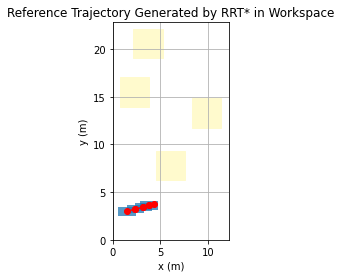

0
Path to goal found with length: 21.40218216410813
Path to goal found with length: 19.49208043074319
Path to goal found with length: 19.316105238877356
500
Path to goal found with length: 19.099273283337812
Path to goal found with length: 19.165963908522855
Path to goal found with length: 19.063657873840175
Path to goal found with length: 18.907582145979884
1000
Path to goal found with length: 18.874747063507527
Path to goal found with length: 18.862489222890748
Path to goal found with length: 18.738069958128328
1500
Path to goal found with length: 18.775124809213523
Path to goal found with length: 18.805080682849066
2000
2500
Path to goal found with length: 18.35644037901675
3000
Path to goal found with length: 17.648256501653545
Path to goal found with length: 17.308807501886086
Path to goal found with length: 17.56907397101148
3500
Path to goal found with length: 17.45904704121695
Path to goal found with length: 17.534097940555537
Path to goal found with length: 17.298300201693404


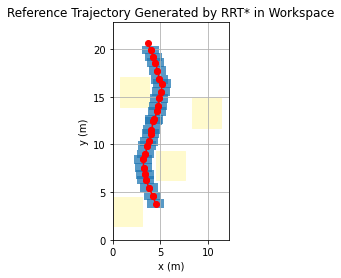

0
Path to goal found with length: 13.686160389670258
500
Path to goal found with length: 10.011459732213186
Path to goal found with length: 10.134623220419453
1000
Path to goal found with length: 9.740553414472359
Path to goal found with length: 9.778555299636261
1500
Path to goal found with length: 9.560244032921982
2000
Path to goal found with length: 9.728391800939363
2500
Path to goal found with length: 9.45980152825836
Path to goal found with length: 9.547184370128008
Path to goal found with length: 9.51329093347066
3000
Path to goal found with length: 9.495362775960327
3500
Path to goal found with length: 9.518956990310144
Path to goal found with length: 9.39681054845312
4000
Path to goal found with length: 9.56197866217275
Path to goal found with length: 9.571716496829534
4500
Path to goal found with length: 9.52526263959274
Path to goal found with length: 9.63567812489069
Task 3 n=5000,m=200,Time since start = 283.6599841117859 sec


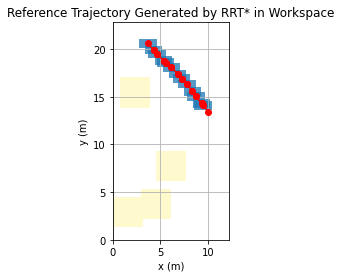

0
500
Path to goal found with length: 7.2424250331970175
Path to goal found with length: 7.514372793785441
Path to goal found with length: 7.418692324517697
Path to goal found with length: 7.134322423676808
1000
Path to goal found with length: 6.7831833130547095
1500
Path to goal found with length: 6.650925012885153
2000
Path to goal found with length: 6.6383537998524185
Path to goal found with length: 6.8664372306500345
Path to goal found with length: 6.807473879961679
Path to goal found with length: 6.819389806175892
2500
Path to goal found with length: 6.70322321839316
Path to goal found with length: 6.520689454950181
Path to goal found with length: 6.53069627583442
3000
Path to goal found with length: 6.76343665815117
3500
4000
Path to goal found with length: 6.694020283996257
Path to goal found with length: 6.625541374507651
Path to goal found with length: 6.6531277271897755
4500
Path to goal found with length: 6.659769676813094
Path to goal found with length: 6.708673380138332
Ta

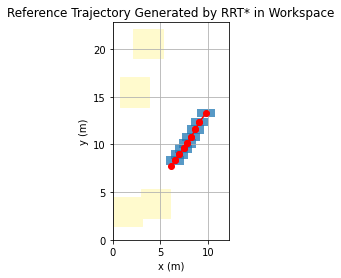

0
500
Path to goal found with length: 9.597380256459413
Path to goal found with length: 9.253031670097128
Path to goal found with length: 9.335679170354664
Path to goal found with length: 9.211792015831529
Path to goal found with length: 9.00117180779273
1000
Path to goal found with length: 9.063285338256135
Path to goal found with length: 8.659905993750723
1500
Path to goal found with length: 8.925167479707804
Path to goal found with length: 8.54822133110141
2000
Path to goal found with length: 8.641894261972498
2500
Path to goal found with length: 8.567195981716521
Path to goal found with length: 8.74506656516514
3000
3500
Path to goal found with length: 8.633593852202482
Path to goal found with length: 8.861115220647296
4000
Path to goal found with length: 8.597659837963052
4500
Path to goal found with length: 8.53703343884432
Path to goal found with length: 8.455996636843919
Task 5 n=5000,m=200,Time since start = 472.9996781349182 sec


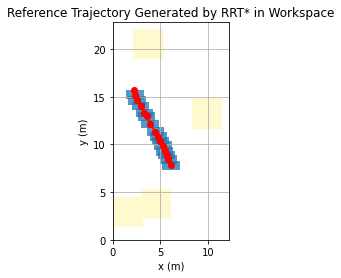

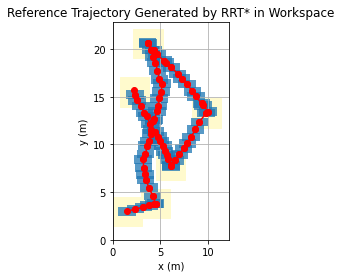

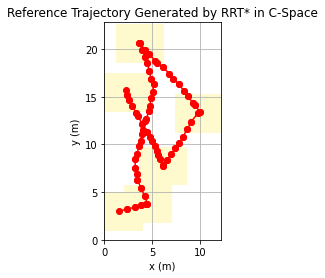

In [14]:
# RUN THIS FOR DEMO
# Example of what task planner output looks like
# Read in from file "preplan.json"
'''
ltlOutput = {
  "length": 1.83,
  "width": 0.91,
  "height": 0.91,
  "poolLength": 22.8,
  "poolWidth": 12.2,
  "poolDepth": 2.4,
  "maxVelX": 1.5,
  "maxVelY": 1,
  "maxVelZ": 0.5,
  "obstLength": 3.05,
  "obstWidth": 3.05,
  "obstHeight": 3.05,
  "coords": [
    [1.5,3,1.2],
    [4.5,3.8,1.2],
    [6.1,7.8,1.2],
    [9.8,13.3,1.2],
    [2.3,15.5,1.2],
    [3.7,20.6,1.2]
  ]
}
'''
# Alternative set of coordinates to test
'''
[[1.5, 3, 1.2],
[4.5, 3.8, 1.2],
[2.3, 15.5, 1.2],
[6.1, 7.8, 1.2],
[3.7, 20.6, 1.2],
[9.8, 13.3, 1.2]]
'''

def loadJSONFromFile(filePath="preplan.json"):
    # import the JSON generated by the MATLAB Script
    preplanFile = open(filePath)
    data = json.load(preplanFile)
    preplanFile.close()
    return data

ltlOutput = loadJSONFromFile()

copy = ltlOutput["coords"][2:]
random.shuffle(copy)
ltlOutput["coords"][2:] = copy 

def getObstacles(taskObstacles):
    # convert obstacles from centers to list of corners
    # side length of cubic obstacles (matplotlib constraint)
    cornerObstacles = []
    l = ltlOutput["obstLength"]
    for Oi in taskObstacles:
        x,y,z = Oi
        v1 = (x-(l/2),y-(l/2))
        v2 = (x+(l/2),y-(l/2))
        v3 = (x+(l/2),y+(l/2))
        v4 = (x-(l/2),y+(l/2))
        cornerObstacle = np.array([v1,v2,v3,v4])
        cornerObstacles.append(cornerObstacle)
    return cornerObstacles

tasks = []
cornerObstacles = getObstacles(ltlOutput["coords"])
# For each task, can only visit the start region and the goal region, all other regions are considered obstacles
for i in range(0,len(ltlOutput["coords"])-1):
    obstacleCenters = ltlOutput["coords"]
    taskObstacles = obstacleCenters[0:i] + obstacleCenters[i+2:]
    qStart = obstacleCenters[i]
    qGoal = obstacleCenters[i+1]
    task = {}
    task["obstacles"] = getObstacles(taskObstacles)
    task["obstacleCenters"] = obstacleCenters[0:i] + obstacleCenters[i+2:]
    task["qStart"] = qStart
    task["qGoal"] = qGoal
    tasks.append(task)
    

fullTrajectory = []
fullLength = 0
t0 = time.time()
for i in range(0,len(tasks)):
    task = tasks[i]
    qStart,qGoal = np.array(task["qStart"]),np.array(task["qGoal"])
    obstacles = task["obstacles"]
    xRange = (0,ltlOutput["poolWidth"])
    yRange = (0,ltlOutput["poolLength"])
    zRange = (0,ltlOutput["poolDepth"])
    xDim,yDim,zDim = ltlOutput["length"],ltlOutput["width"],ltlOutput["height"]

    r = rrtPlanner(obstacles,xRange,yRange,zRange,qStart,qGoal,(xDim,yDim,zDim))
    
    pathExists,tree,qGoal,pathLength = r.generateTree(n=5000,r=0.5,pGoal=0.05,epsilon=0.25)

    if pathExists:
        newTrajectory = r.getTrajectory()
        fullTrajectory = fullTrajectory + newTrajectory
        fullLength += pathLength
        print(f"Task {i+1} n=5000,m=200,Time since start = {time.time()-t0} sec")
        displayTrajectory2D(r,newTrajectory,plotCSpace=False,displayTree=False)

        
    else:
        print("Failed to find path")
        break


# For plotting purposes    
qStart,qGoal = np.array(task["qStart"]),np.array(task["qGoal"])
obstacles = cornerObstacles
xRange = (0,ltlOutput["poolWidth"])
yRange = (0,ltlOutput["poolLength"])
zRange = (0,ltlOutput["poolDepth"])
xDim,yDim,zDim = ltlOutput["length"],ltlOutput["width"],ltlOutput["height"]

r = rrtPlanner(obstacles,xRange,yRange,zRange,qStart,qGoal,(xDim,yDim,zDim))
r.obstacles = cornerObstacles
displayTrajectory2D(r,fullTrajectory,False)
displayTrajectory2D(r,fullTrajectory,True)

0
Path to goal found with length: 13.533254190389144
500
Path to goal found with length: 11.243309251486235
Path to goal found with length: 11.025682267891938
Path to goal found with length: 10.641818183534342
1000
Path to goal found with length: 9.957696674509908
Path to goal found with length: 10.105861923700173
1500
Path to goal found with length: 10.2520432561137
Path to goal found with length: 10.204398279700508
Path to goal found with length: 10.13378448673798
2000
Path to goal found with length: 10.286009932741427


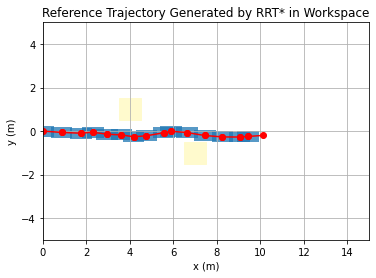

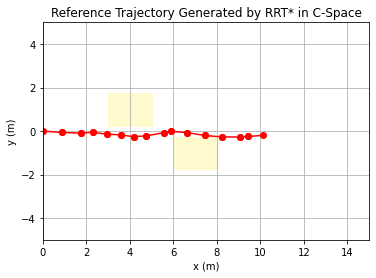

In [16]:
O1 = np.array([(3.5,0.5),(4.5,0.5),(4.5,1.5),(3.5,1.5)])
O2 = np.array([(6.5,-1.5),(7.5,-1.5),(7.5,-0.5),(6.5,-0.5)])
obstacles = [O1,O2]
qStart = np.array([0,0,0])
qGoal = np.array([10,0,0])
xRange = (0,15)
yRange = (-5,5)
zRange = (-5,5)
xDim,yDim,zDim = 1,0.5,3 # width,length,and height of the AUV

r = rrtPlanner(obstacles,xRange,yRange,zRange,qStart,qGoal,(xDim,yDim,zDim))

pathExists,tree,qGoal,pathLength = r.generateTree(n=2500,r=0.5,pGoal=0.05,epsilon=0.25)

if pathExists:
    trajectory = r.getTrajectory()
    displayTrajectory2D(r,trajectory,False)
    displayTrajectory2D(r,trajectory,True)